In [3]:
import os

HOME_DIR = '/Users/yoav/Documents/Yoav/CS/20936 - DS Project/Shotpred'
DATA_DIR = os.path.join(HOME_DIR, 'data')
EXT_DATA_DIR = os.path.join(DATA_DIR, 'External')
INT_DATA_DIR = os.path.join(DATA_DIR, 'Internal')

import sys
sys.path.append("/Users/yoav/Documents/Yoav/CS/20936 - DS Project/Shotpred/utils")

In [4]:
import pandas as pd
import os
from nba_api.stats.endpoints import playerindex, playbyplayv3

import data_utils as du

import importlib
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt


In [5]:
KAGGLE_SHOT_LOGS_201415_FILENAME = 'kaggle_shot_logs_2014_15.csv'
KAGGLE_SHOT_LOGS_201415_FULLPATH = os.path.join(EXT_DATA_DIR, KAGGLE_SHOT_LOGS_201415_FILENAME)

GENERAL_SHOT_LOGS_FILENAME = 'nba_2015_shots.csv'
GENERAL_SHOT_LOGS_FULLPATH = os.path.join(EXT_DATA_DIR, GENERAL_SHOT_LOGS_FILENAME)

In [6]:
KAGGLE_COLS_FOR_MERGE = ['GAME_ID', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'player_id', 'absolute_game_time']
CAREER_STATS_COL_FOR_MERGE = ['PLAYER_ID', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT'] #already filtered for relevant season

In [7]:
shot_logs_1415 = pd.read_csv(KAGGLE_SHOT_LOGS_201415_FULLPATH)

In [8]:
active_players_201415_ids = shot_logs_1415['player_id'].unique()

In [9]:
shot_logs_1415['absolute_game_time'] = shot_logs_1415.apply(lambda row: du.clock_to_absolute_seconds(row['GAME_CLOCK'], row['PERIOD']), axis=1)

In [10]:
#active_players_career_stats = du.gather_mul_career_stats(active_players_201415_ids) # get the career stats for all active players in 2014-15 season

In [11]:
#active_players_cs_in_1415 = active_players_career_stats[active_players_career_stats['SEASON_ID'] == '2014-15'].reset_index(drop=True)
#active_players_cs_in_1415.to_csv(INT_DATA_DIR + 'active_players_career_stats_2014_15.csv', index=False)

In [12]:
active_players_cs_in_1415 = pd.read_csv(os.path.join(INT_DATA_DIR, 'active_players_career_stats_2014_15.csv'))

In [13]:
gen_sl = pd.read_csv(GENERAL_SHOT_LOGS_FULLPATH)

In [14]:
gen_sl['absolute_game_time'] = gen_sl.apply(lambda row: du.clock_to_absolute_seconds(f"{str(row["MINS_LEFT"]).zfill(2)}:{str(row["SECS_LEFT"]).zfill(2)}", row['QUARTER']), axis=1)

In [15]:
kaggle_for_join = shot_logs_1415[KAGGLE_COLS_FOR_MERGE]

In [16]:
kaggle_for_join.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time
0,21400899,10.8,2,1.9,"Anderson, Alan",101187,1.3,203148,651.0
1,21400899,3.4,0,0.8,"Bogdanovic, Bojan",202711,6.1,203148,706.0
2,21400899,NaN,3,2.7,"Bogdanovic, Bojan",202711,0.9,203148,720.0
3,21400899,10.3,2,1.9,"Brown, Markel",203900,3.4,203148,733.0
4,21400899,10.9,2,2.7,"Young, Thaddeus",201152,1.1,203148,806.0


In [17]:
gen_sl_game_ids = set(gen_sl['GAME_ID'].unique())
kaggle_for_join_game_ids = set(kaggle_for_join['GAME_ID'].unique())

common_game_ids = gen_sl_game_ids.intersection(kaggle_for_join_game_ids)

print(f"Number of unique GAME_IDs in gen_sl: {len(gen_sl_game_ids)}")
print(f"Number of unique GAME_IDs in kaggle_for_join: {len(kaggle_for_join_game_ids)}")
print(f"Number of common GAME_IDs in both: {len(common_game_ids)}")

Number of unique GAME_IDs in gen_sl: 1230
Number of unique GAME_IDs in kaggle_for_join: 904
Number of common GAME_IDs in both: 904


In [18]:
kaggle_for_join = kaggle_for_join.sort_values(by=['absolute_game_time']).reset_index(drop=True)

In [19]:
gen_sl = gen_sl.sort_values(by=['absolute_game_time']).reset_index(drop=True)
gen_sl['gen_sl_time_copy'] = gen_sl['absolute_game_time']

In [20]:
merged = pd.merge_asof(kaggle_for_join, gen_sl, on='absolute_game_time',left_by=['player_id', 'GAME_ID'], right_by=['PLAYER_ID', 'GAME_ID'],  direction='nearest', suffixes=['_kaggle', '_shot_logs'], tolerance=5) #,left_by=['player_id', 'GAME_ID'], right_by=['PLAYER_ID', 'GAME_ID'], 

In [21]:
merged

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,gen_sl_time_copy
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,2015.0,...,Center,C,Less Than 8 ft.,-0.6,5.35,0.0,1.0,11.0,54.0,6.0
1,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,2015.0,...,Center,C,Less Than 8 ft.,1.5,6.45,1.0,1.0,11.0,51.0,9.0
2,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,2015.0,...,Center,C,Less Than 8 ft.,-0.0,5.35,0.0,1.0,11.0,55.0,5.0
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,2015.0,...,Center,C,Less Than 8 ft.,-2.2,6.65,2.0,1.0,11.0,54.0,6.0
4,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,2015.0,...,Center,C,Less Than 8 ft.,-2.4,5.05,2.0,1.0,11.0,52.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400164,8.0,0,0.8,"Ilyasova, Ersan",101141,6.6,202711,5018.0,2015.0,...,Left Side Center,LC,24+ ft.,11.1,26.95,24.0,7.0,0.0,19.0,5021.0
128065,21400375,0.7,1,2.1,"Duncan, Tim",1495,9.8,201584,5023.0,2015.0,...,Left Side,L,16-24 ft.,19.4,11.65,20.0,7.0,0.0,17.0,5023.0
128066,21400164,NaN,0,0.8,"Antetokounmpo, Giannis",203507,3.9,2207,5030.0,2015.0,...,Right Side,R,16-24 ft.,-16.6,4.95,16.0,7.0,0.0,7.0,5033.0
128067,21400375,NaN,9,6.4,"Gasol, Marc",201188,5.1,1938,5035.0,2015.0,...,Right Side Center,RC,24+ ft.,-13.3,29.35,27.0,7.0,0.0,3.0,5037.0


In [22]:
not_merged = merged[merged.gen_sl_time_copy.isna()]

In [23]:
not_merged.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,gen_sl_time_copy
145,21400345,11.6,2,5.0,"Conley, Mike",201144,0.3,203487,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,21400471,22.9,0,2.1,"Hill, Jordan",201941,2.6,202389,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,21400872,11.2,0,0.0,"Amundson, Lou",200811,3.7,202685,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,21400322,10.9,0,4.6,"Joseph, Cory",202709,2.9,101181,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,21400515,9.6,5,4.1,"Holiday, Jrue",201950,5.7,202322,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
heights = pd.read_csv(os.path.join(INT_DATA_DIR, 'nba_2014_2015_player_heights_with_ids.csv'))

In [25]:
heights

,PLAYER_NAME,HEIGHT,PLAYER_ID
0,AJ Price,6-2,201985.0
1,Aaron Brooks,6-0,201166.0
2,Aaron Gordon,6-8,203932.0
3,Adreian Payne,6-10,203940.0
4,Al Horford,6-9,201143.0
...,...,...,...
479,Xavier Henry,6-6,202333.0
480,Zach LaVine,6-5,203897.0
481,Zach Randolph,6-9,2216.0
482,Zaza Pachulia,6-11,2585.0


In [26]:
# Merge for attacker heights
merged_with_attacker_heights = pd.merge(merged, heights, left_on='PLAYER_NAME', right_on='PLAYER_NAME', suffixes=('', '_attacker'))

# !!!!!!Merge for defender heights - CAUSES NULL VALUES BECAUSE OF THE DIFFERENT PLAYER NAMES AND LEFT JOIN - NEED IDS!!!!!
merged_with_both_heights = pd.merge(merged_with_attacker_heights, heights, left_on='CLOSEST_DEFENDER_PLAYER_ID', right_on='PLAYER_ID', suffixes=('', '_defender'), how='left')

# Drop the extra PLAYER_NAME column from the second merge
merged_with_both_heights = merged_with_both_heights.drop(columns=['PLAYER_NAME_defender'])

merged_with_both_heights

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,gen_sl_time_copy,HEIGHT,PLAYER_ID_attacker,HEIGHT_defender,PLAYER_ID_defender
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,2015.0,...,5.35,0.0,1.0,11.0,54.0,6.0,6-4,2754.0,6-2,202709.0
1,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,2015.0,...,6.45,1.0,1.0,11.0,51.0,9.0,6-9,202693.0,6-3,201565.0
2,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,2015.0,...,5.35,0.0,1.0,11.0,55.0,5.0,6-9,202693.0,6-11,201586.0
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,2015.0,...,6.65,2.0,1.0,11.0,54.0,6.0,6-3,203463.0,6-6,203095.0
4,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,2015.0,...,5.05,2.0,1.0,11.0,52.0,8.0,6-8,2772.0,6-6,201960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124542,21400375,6.3,17,17.7,"Duncan, Tim",1495,5.0,201144,5017.0,2015.0,...,22.85,17.0,7.0,0.0,20.0,5020.0,6-0,201144.0,6-11,1495.0
124543,21400375,0.7,1,2.1,"Duncan, Tim",1495,9.8,201584,5023.0,2015.0,...,11.65,20.0,7.0,0.0,17.0,5023.0,6-5,201584.0,6-11,1495.0
124544,21400164,NaN,0,0.8,"Antetokounmpo, Giannis",203507,3.9,2207,5030.0,2015.0,...,4.95,16.0,7.0,0.0,7.0,5033.0,6-7,2207.0,6-11,203507.0
124545,21400375,NaN,9,6.4,"Gasol, Marc",201188,5.1,1938,5035.0,2015.0,...,29.35,27.0,7.0,0.0,3.0,5037.0,6-6,1938.0,6-11,201188.0


In [27]:
COLS_FOR_PRED = ['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'absolute_game_time', 'SEASON_1', 'SEASON_2', 'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'HOME_TEAM', 'AWAY_TEAM', 'SHOT_MADE', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'HEIGHT', 'HEIGHT_defender']
COLS_FOR_PRED.extend(CAREER_STATS_COL_FOR_MERGE)

# interchange SEASON1/SEASON2
# maybe the game date is highly correlated with season so leave only game date
# probably need to chose only subset of the game time/qtr/mins_left/secs_left features
# SHOT_MADE and EVENT_TYPE is g.t

In [28]:
cs_for_merge = active_players_cs_in_1415[CAREER_STATS_COL_FOR_MERGE]
for_pred = pd.merge(merged_with_both_heights, cs_for_merge, on='PLAYER_ID')

In [29]:
#for_pred.head(1000).to_csv(os.path.join(INT_DATA_DIR, 'for_pred.csv'), index=False)

In [30]:
for_pred=for_pred[COLS_FOR_PRED]

In [31]:
for_pred[COLS_FOR_PRED].columns

Index(['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'absolute_game_time', 'SEASON_1', 'SEASON_2',
       'TEAM_ID', 'PLAYER_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION',
       'GAME_DATE', 'HOME_TEAM', 'AWAY_TEAM', 'SHOT_MADE', 'ACTION_TYPE',
       'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y',
       'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'HEIGHT',
       'HEIGHT_defender', 'PLAYER_ID', 'PLAYER_ID', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT'],
      dtype='object')

In [49]:
def visualize_distributions(df, numerical_cols):
    """
    Create visualizations for data distributions
    """
    
    # Distribution plots for numerical columns
    plt.figure(figsize=(15, 5 * (len(numerical_cols) // 3 + 1)))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(len(numerical_cols) // 3 + 1, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

In [53]:
def visualize_heatmap(df, numerical_cols):
    """
    Create a heatmap for the correlation matrix of the given columns
    """

    # Correlation heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

In [51]:
numerical_cols = for_pred.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop(['PLAYER_ID', 'CLOSEST_DEFENDER_PLAYER_ID', 'SEASON_1'])

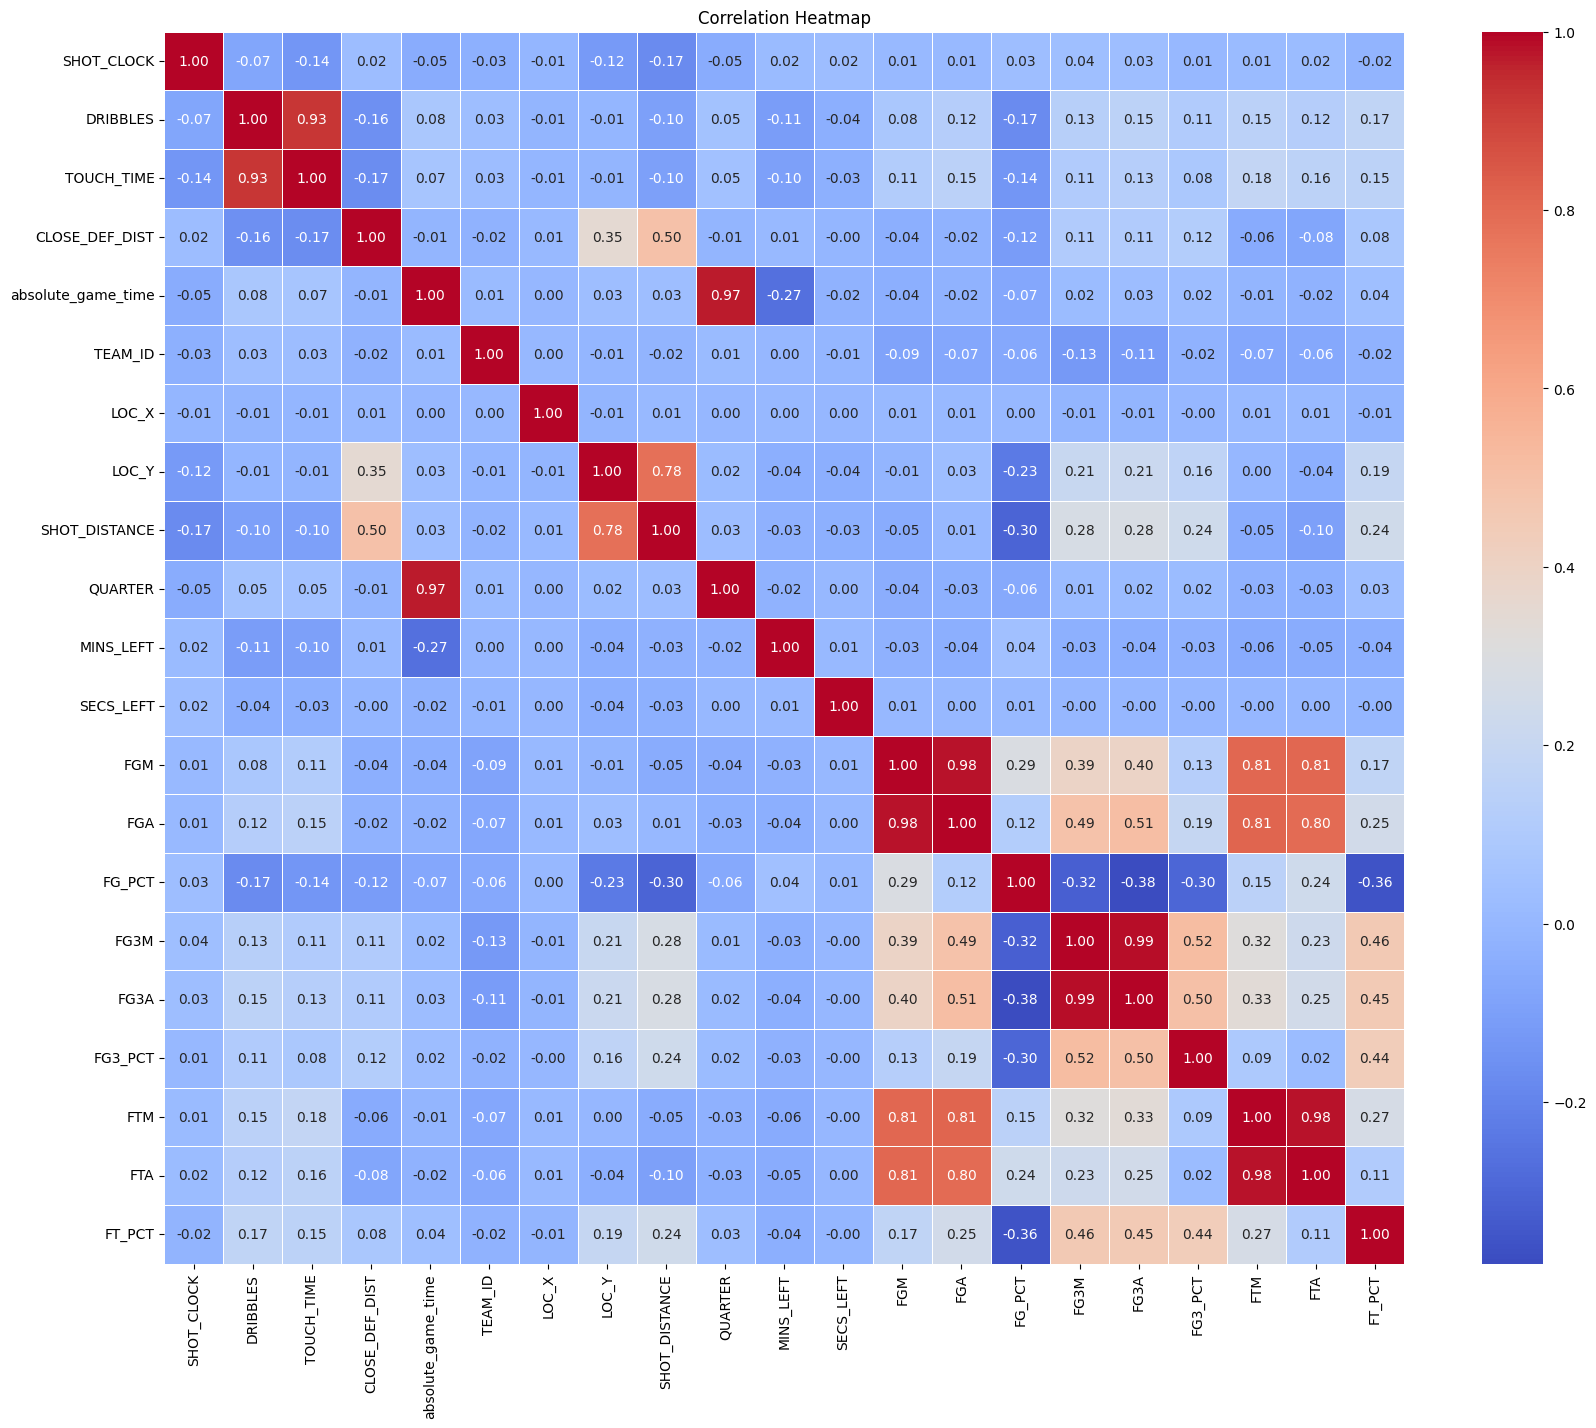

In [54]:
visualize_heatmap(for_pred, numerical_cols)

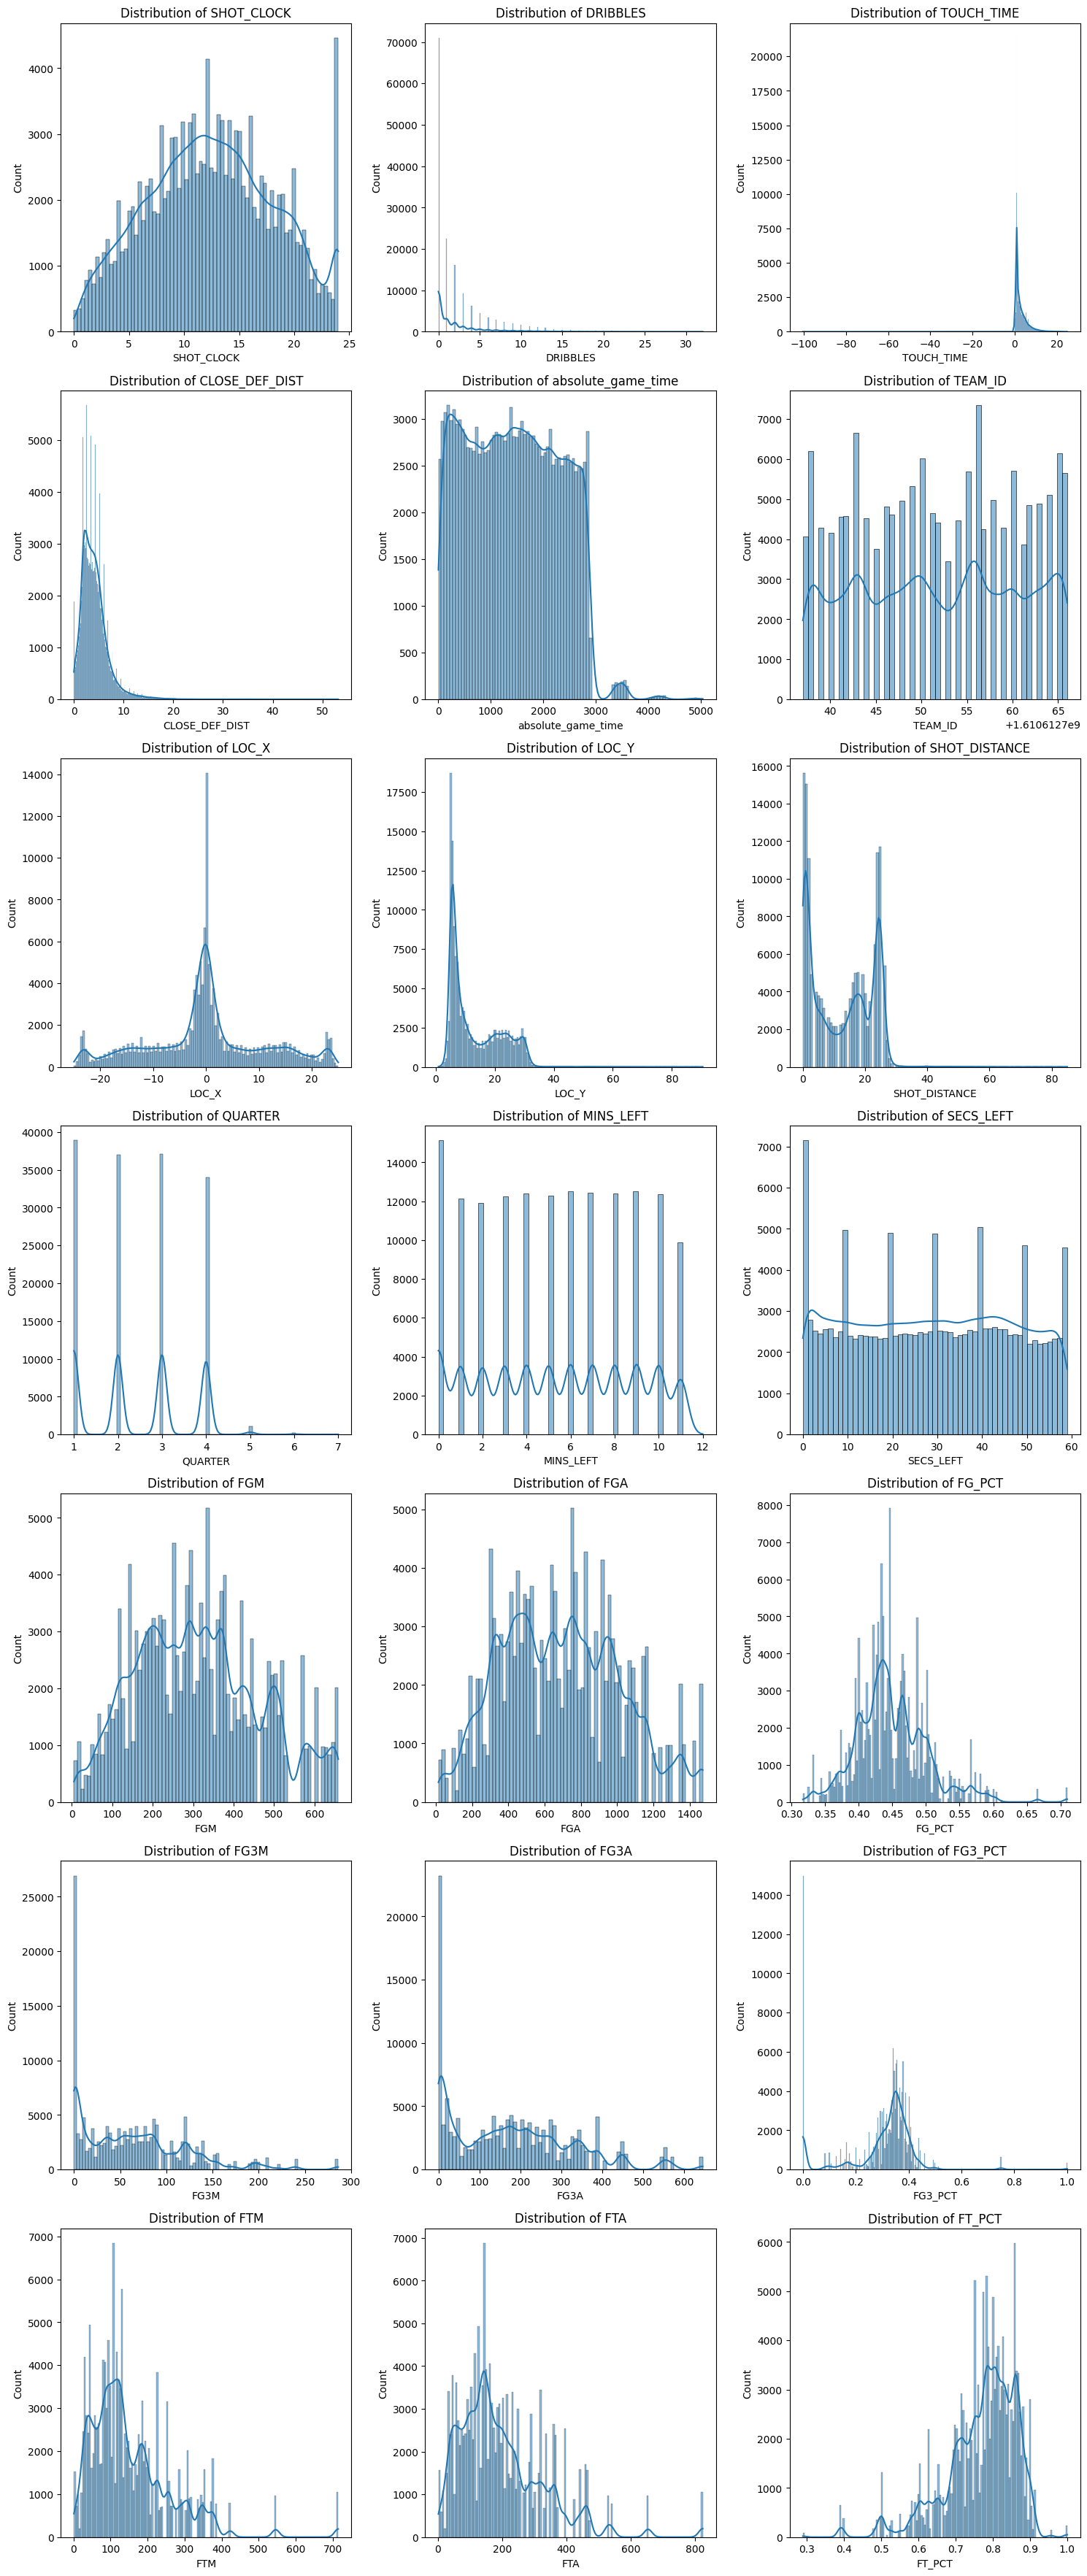

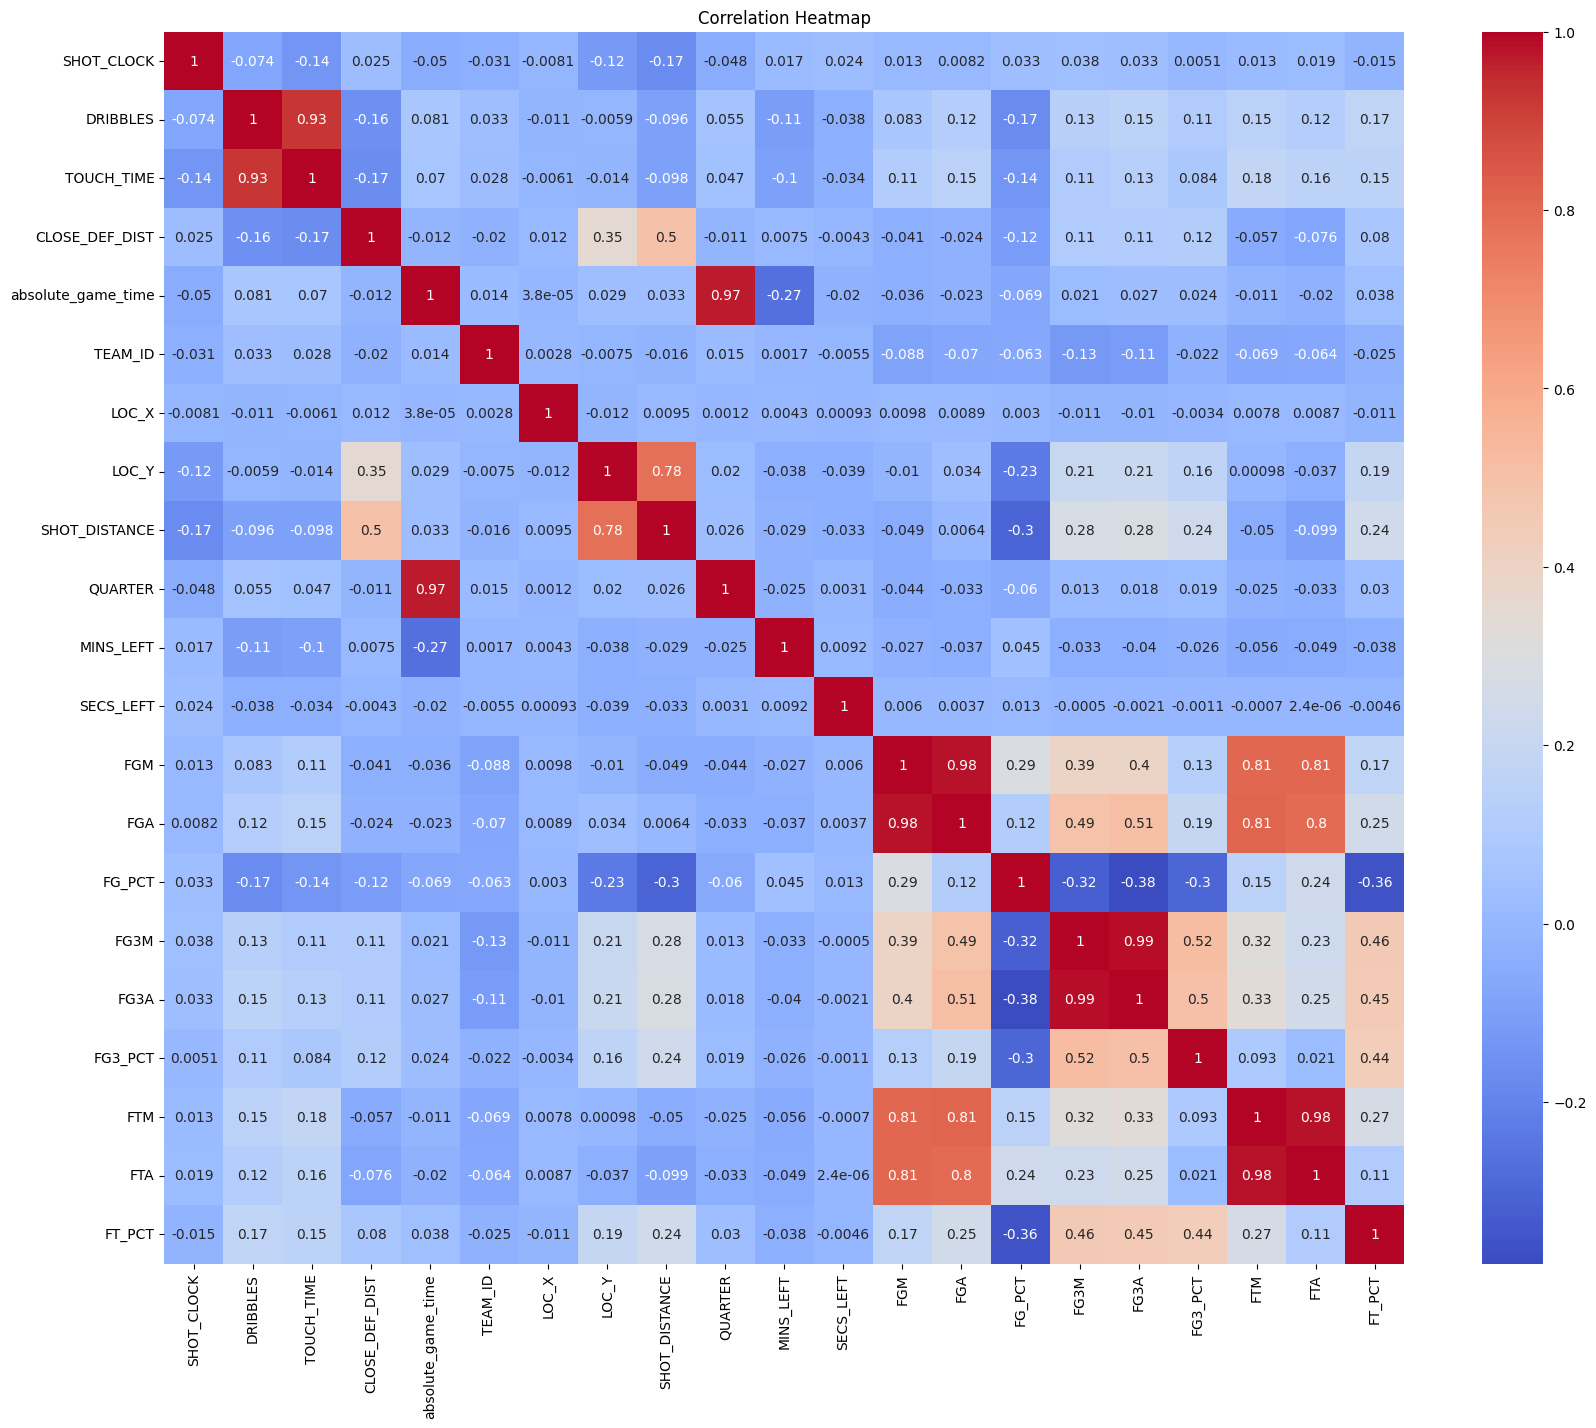

In [48]:
visualize_distributions(X)

In [34]:
importlib.reload(du)
missing_summary = du.missing_values_summary(for_pred)
print(missing_summary)

                 Missing Values  Percentage
SHOT_CLOCK                 6320    4.263731
HEIGHT_defender            3674    2.478631
HEIGHT                      192    0.129531


In [35]:
# check for duplicate rows in the data for prediction
duplicate_rows = for_pred[for_pred.duplicated()]

# display the duplicate rows
print(duplicate_rows)


        SHOT_CLOCK  DRIBBLES  TOUCH_TIME  CLOSEST_DEFENDER_PLAYER_ID  \
2178          24.0         0         0.0                      101187   
8009          24.0         0         0.0                        2561   
23516         22.5         0         0.0                      201959   
72122         10.0         0         0.0                      202694   
95878         24.0         0         0.0                      203096   
114002         8.5         0         1.0                        2210   
114316        21.5         2         2.5                      201572   
120840        11.6         3         5.7                      203475   
120841        11.6         3         5.7                      203475   
120842        11.6         3         5.7                      203475   
123677        12.0         2         3.3                        2747   
125510        17.0         0         0.9                        2747   
125571        13.5         3         5.7                        

In [36]:
for_pred = for_pred.drop_duplicates().reset_index(drop=True)

In [55]:
importlib.reload(du)
constant_columns = du.find_constant_columns(for_pred)
print("Columns with constant values:", constant_columns)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [38]:
# IMPLEMENT - DROP THE CONSTANT COLS, DEFINITELY SEASON_1

In [39]:
for_pred

,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,absolute_game_time,SEASON_1,SEASON_2,TEAM_ID,PLAYER_ID,...,PLAYER_ID,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT
0,22.0,2,1.8,202709,2.3,3.0,2015.0,2014-15,1.610613e+09,2754.0,...,2754.0,225,455,0.495,10,29,0.345,79,126,0.627
1,21.8,3,3.2,201565,5.3,4.0,2015.0,2014-15,1.610613e+09,202693.0,...,202693.0,512,1100,0.465,57,179,0.318,177,232,0.763
2,20.6,0,0.0,201586,4.0,4.0,2015.0,2014-15,1.610613e+09,202693.0,...,202693.0,512,1100,0.465,57,179,0.318,177,232,0.763
3,21.1,0,1.3,203095,3.4,4.0,2015.0,2014-15,1.610613e+09,203463.0,...,203463.0,363,831,0.437,140,391,0.358,130,160,0.813
4,22.5,2,2.5,201960,3.5,4.0,2015.0,2014-15,1.610613e+09,2772.0,...,2772.0,366,910,0.402,194,555,0.350,122,143,0.853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148201,6.3,17,17.7,1495,5.0,5017.0,2015.0,2014-15,1.610613e+09,201144.0,...,201144.0,393,882,0.446,107,277,0.386,214,249,0.859
148202,0.7,1,2.1,1495,9.8,5023.0,2015.0,2014-15,1.610613e+09,201584.0,...,201584.0,288,643,0.448,90,224,0.402,111,129,0.860
148203,NaN,0,0.8,203507,3.9,5030.0,2015.0,2014-15,1.610613e+09,2207.0,...,2207.0,446,1025,0.435,121,337,0.359,141,176,0.801
148204,NaN,9,6.4,201188,5.1,5035.0,2015.0,2014-15,1.610613e+09,1938.0,...,1938.0,251,589,0.426,89,258,0.345,147,204,0.721


In [40]:
target_column = 'SHOT_MADE'

In [41]:
X = for_pred.drop(target_column, axis=1)
y = for_pred[target_column]

In [42]:
X.columns

Index(['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'absolute_game_time', 'SEASON_1', 'SEASON_2',
       'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION', 'GAME_DATE',
       'HOME_TEAM', 'AWAY_TEAM', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_NAME',
       'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER',
       'MINS_LEFT', 'SECS_LEFT', 'HEIGHT', 'HEIGHT_defender', 'PLAYER_ID',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT'],
      dtype='object')

In [43]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [44]:
all_columns = set(X.columns)
numerical_and_categorical = set(numerical_cols).union(set(categorical_cols))
other_columns = all_columns - numerical_and_categorical

print("Columns that are not in numerical or categorical:")
print(other_columns)

Columns that are not in numerical or categorical:
set()


In [42]:
# Handle missing values

num_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

In [43]:
# Categorical imputer for missing values
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

In [44]:
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    X[col] = encoders[col].fit_transform(X[col])

In [45]:
# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols]) # zero mean and unit variance for the numerical columns

In [46]:
X

,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,absolute_game_time,SEASON_1,SEASON_2,TEAM_ID,PLAYER_ID,...,PLAYER_ID,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT
0,1.698260e+00,-0.038732,-0.341960,0.552940,-0.658734,-1.678407,0.0,0,1.289308,-1.993054,...,-1.993054,-0.562245,-0.715275,0.866176,-0.952135,-1.026439,0.330812,-0.663418,-0.516568,-1.521742
1,1.662676e+00,0.239817,0.116440,0.538405,0.434992,-1.677231,0.0,0,0.485202,0.555559,...,0.555559,1.315034,1.266436,0.299634,-0.120706,-0.004598,0.118739,0.234258,0.280222,-0.080685
2,1.449172e+00,-0.595831,-0.931332,0.538671,-0.038956,-1.677231,0.0,0,0.485202,0.555559,...,0.555559,1.315034,1.266436,0.299634,-0.120706,-0.004598,0.118739,0.234258,0.280222,-0.080685
3,1.538132e+00,-0.595831,-0.505674,0.557845,-0.257701,-1.677231,0.0,0,0.714946,0.565374,...,0.565374,0.340419,0.439955,-0.229139,1.347562,1.439604,0.432921,-0.196260,-0.260994,0.449116
4,1.787219e+00,-0.038732,-0.112760,0.543423,-0.221244,-1.677231,0.0,0,-0.778393,-1.992825,...,-1.992825,0.360042,0.682676,-0.890106,2.302821,2.556816,0.370084,-0.269539,-0.388781,0.872956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148201,-1.095079e+00,4.139512,4.864156,-2.003666,0.325619,4.218336,0.0,0,1.289308,0.535814,...,0.535814,0.536650,0.596648,-0.059177,0.763793,0.663005,0.652848,0.573177,0.408009,0.936532
148202,-2.091430e+00,-0.317282,-0.243731,-2.003666,2.075580,4.225393,0.0,0,1.289308,0.541423,...,0.541423,-0.150159,-0.137660,-0.021407,0.463063,0.301954,0.778521,-0.370299,-0.494017,0.947128
148203,3.160489e-16,-0.595831,-0.669389,0.563080,-0.075414,4.233625,0.0,0,-0.089160,-2.000027,...,-2.000027,0.883326,1.036004,-0.266909,1.011453,1.071741,0.440775,-0.095500,-0.140724,0.321963
148204,3.160489e-16,1.911115,1.164212,0.533615,0.362077,4.239505,0.0,0,0.829819,-2.003456,...,-2.003456,-0.392178,-0.303571,-0.436872,0.445374,0.533572,0.330812,-0.040540,0.069749,-0.525717


In [47]:
importlib.reload(du)
X_train, X_val, X_test, y_train, y_val, y_test = du.split_dataset(X, y, test_size=0.1, validation_size=0.2, random_state=2312)

In [48]:
X_train.columns

Index(['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'absolute_game_time', 'SEASON_1', 'SEASON_2',
       'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION', 'GAME_DATE',
       'HOME_TEAM', 'AWAY_TEAM', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_NAME',
       'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER',
       'MINS_LEFT', 'SECS_LEFT', 'HEIGHT', 'HEIGHT_defender', 'PLAYER_ID',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT'],
      dtype='object')

In [49]:
X_train.dropna()

,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,absolute_game_time,SEASON_1,SEASON_2,TEAM_ID,PLAYER_ID,...,PLAYER_ID,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT
124740,-0.792616,0.796917,0.771298,0.538506,-0.002499,1.160592,0.0,0,0.485202,0.556133,...,0.556133,-0.608032,-0.540147,-0.436872,0.303854,0.186146,0.692121,0.298378,0.122367,1.074280
102827,0.470614,-0.595831,-0.669389,0.552584,1.674548,0.629015,0.0,0,1.633925,0.561359,...,0.561359,-0.882756,-0.724492,-1.135607,-0.032256,0.090774,0.142302,-0.782497,-0.907445,1.286200
93034,-0.721448,0.239817,0.214669,0.528647,0.398534,0.402036,0.0,0,-0.089160,-2.000027,...,-2.000027,0.883326,1.036004,-0.266909,1.011453,1.071741,0.440775,-0.095500,-0.140724,0.321963
100347,0.079190,1.354016,0.214669,-1.987593,0.033959,0.570212,0.0,0,-0.318904,0.555495,...,0.555495,-1.700387,-1.673870,-1.739919,-0.757545,-0.767572,0.079466,-1.167215,-1.245705,0.608056
113846,-0.383401,-0.595831,-0.603903,0.533208,1.200600,0.888923,0.0,0,-0.433777,0.541576,...,0.541576,-0.287521,-0.076212,-0.871221,0.162334,0.465449,-0.069770,0.499897,0.535796,0.035871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117821,-0.988328,-0.595831,-0.603903,-0.737700,0.070417,0.988888,0.0,0,-0.433777,-1.995693,...,-1.995693,0.209598,0.175727,0.205210,-0.014566,-0.079533,0.566448,0.252578,0.280222,0.014679
120281,-2.073638,0.518367,0.705812,-1.990084,-0.804564,1.050042,0.0,0,1.174436,0.565897,...,0.565897,0.386206,0.974556,-1.532187,1.064523,1.432792,0.118739,-0.388619,-0.373747,-0.197241
113931,1.893971,-0.595831,-0.833103,0.552762,0.033959,0.891275,0.0,0,0.370330,0.565795,...,0.565795,-0.078208,0.209523,-1.003414,1.825192,1.814279,0.558594,0.243418,0.167468,0.523288
13622,-0.347817,-0.317282,0.640326,-0.737307,-0.184786,-1.384393,0.0,0,1.519053,0.550906,...,0.550906,0.732882,0.507548,0.885061,-1.129035,-1.223995,-2.379008,0.921255,1.061977,-0.218433


In [50]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Initialize the logistic regression model with L2 regularization
logistic_model_l2 = LogisticRegression(max_iter=1000, random_state=2312)
logistic_model_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=2312)

# Fit the model on the training data
logistic_model_l2.fit(X_train, y_train)
logistic_model_l1.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='l1', random_state=2312,
                   solver='liblinear')

In [76]:
print(logistic_model_l2.score(X_train, y_train),logistic_model_l1.score(X_train, y_train))

0.6170109082730442 0.6168515950069348


In [77]:
y_val_pred_l2 = logistic_model_l2.predict(X_val)
y_val_pred_l1 = logistic_model_l1.predict(X_val)

In [78]:
y_test_pred_l2 = logistic_model_l2.predict(X_test)
y_test_pred_l1 = logistic_model_l1.predict(X_test)

In [79]:
accuracy_score(y_test, y_test_pred_l2), accuracy_score(y_test, y_test_pred_l1)

(0.6177720801565346, 0.61824438297011)

In [80]:
accuracy_score(y_val, y_val_pred_l2), accuracy_score(y_val, y_val_pred_l1)

(0.6162986842598493, 0.6164111406829853)

Accuracy: 0.6163
Precision: 0.5849
Recall: 0.4416
F1 Score: 0.5033
ROC AUC: 0.5976


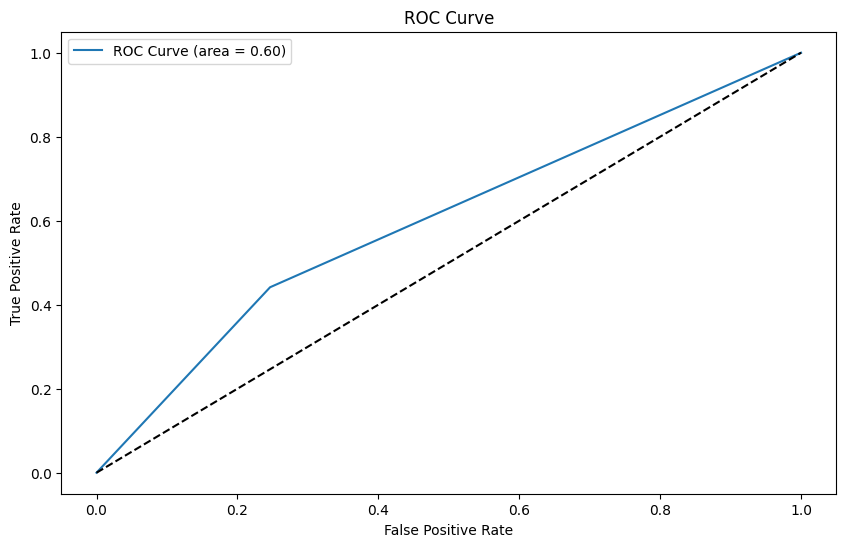

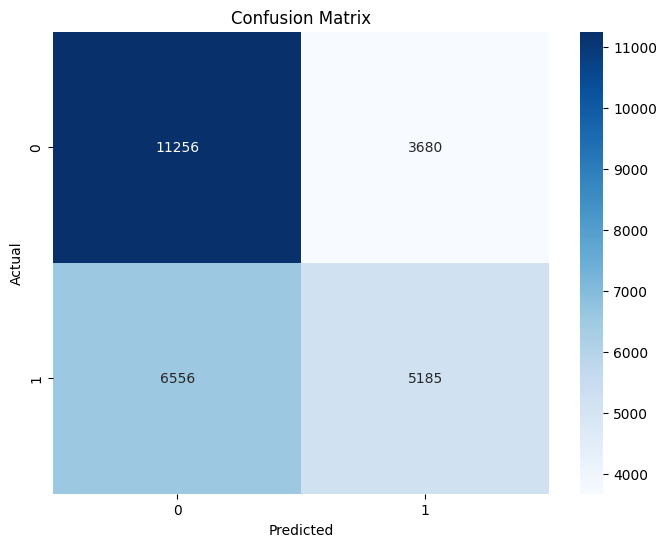

In [81]:
# Calculate metrics for l2
accuracy = accuracy_score(y_val, y_val_pred_l2)
precision = precision_score(y_val, y_val_pred_l2)
recall = recall_score(y_val, y_val_pred_l2)
f1 = f1_score(y_val, y_val_pred_l2)
roc_auc = roc_auc_score(y_val, y_val_pred_l2)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_l2)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_l2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.6164
Precision: 0.5849
Recall: 0.4426
F1 Score: 0.5039
ROC AUC: 0.5978


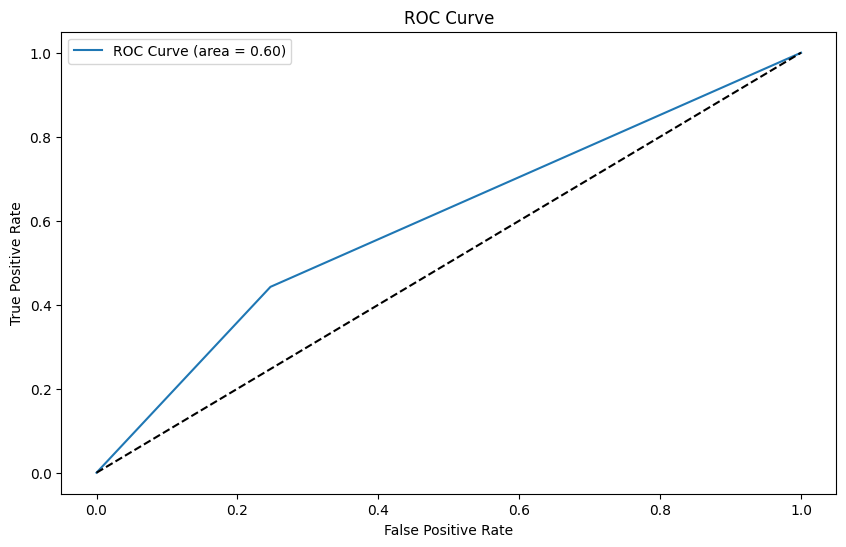

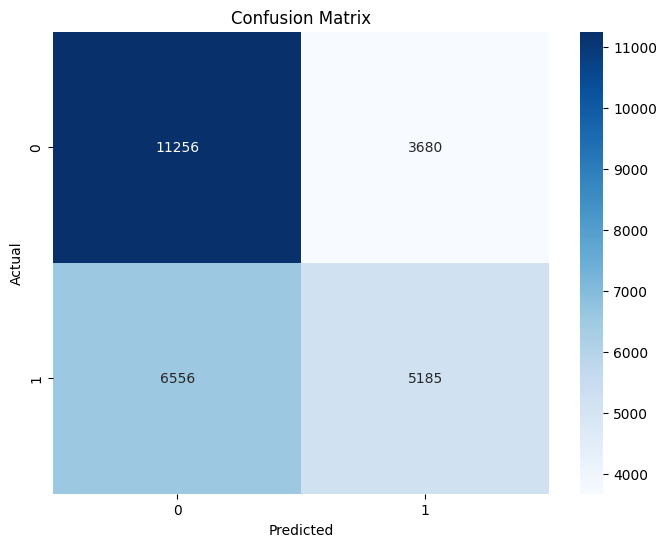

In [82]:
# Calculate metrics for l2
accuracy = accuracy_score(y_val, y_val_pred_l1)
precision = precision_score(y_val, y_val_pred_l1)
recall = recall_score(y_val, y_val_pred_l1)
f1 = f1_score(y_val, y_val_pred_l1)
roc_auc = roc_auc_score(y_val, y_val_pred_l1)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_l1)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_l2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

SVM

In [59]:
# check the class balance. if balanced, we don't need to use class_weight='balanced'
y.value_counts()

SHOT_MADE
False    82708
True     65498
Name: count, dtype: int64

In [60]:
from sklearn import svm

# Initialize the SVM model
svm_model = svm.SVC(random_state=2312, cache_size=800)

In [61]:
svm_model.fit(X_train, y_train)

SVC(cache_size=800, random_state=2312)

In [62]:
#svm_model.score(X_train, y_train)

In [63]:
svm_val_pred = svm_model.predict(X_val)

In [65]:
svm_val_pred

array([0, 0, 0, ..., 1, 1, 0])

In [68]:
accuracy = accuracy_score(y_val, svm_val_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6176


Accuracy: 0.6176
Precision: 0.6597
Recall: 0.2711
F1 Score: 0.3843
ROC AUC: 0.5806


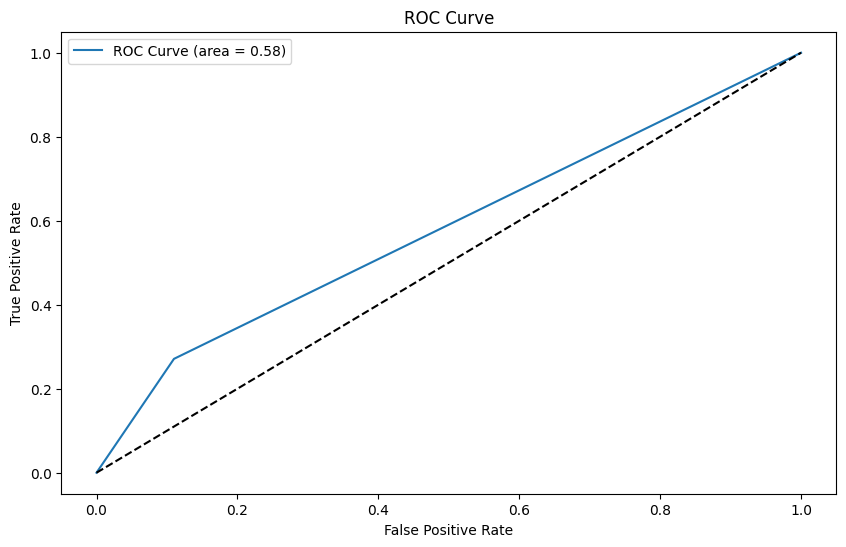

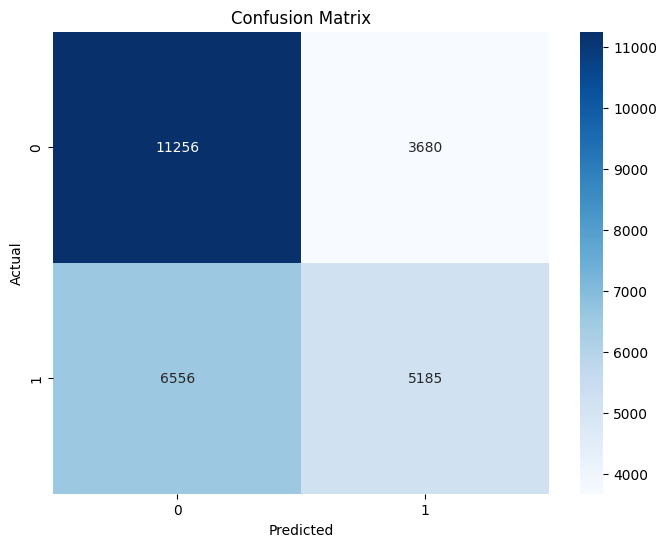

In [70]:
accuracy = accuracy_score(y_val, svm_val_pred)
precision = precision_score(y_val, svm_val_pred)
recall = recall_score(y_val, svm_val_pred)
f1 = f1_score(y_val, svm_val_pred)
roc_auc = roc_auc_score(y_val, svm_val_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, svm_val_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [69]:
svm_test_pred = svm_model.predict(X_test)

In [71]:
accuracy = accuracy_score(y_test, svm_test_pred)
precision = precision_score(y_test, svm_test_pred)
recall = recall_score(y_test, svm_test_pred)
f1 = f1_score(y_test, svm_test_pred)
roc_auc = roc_auc_score(y_test, svm_test_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.6184
Precision: 0.6631
Recall: 0.2735
F1 Score: 0.3872
ROC AUC: 0.5819


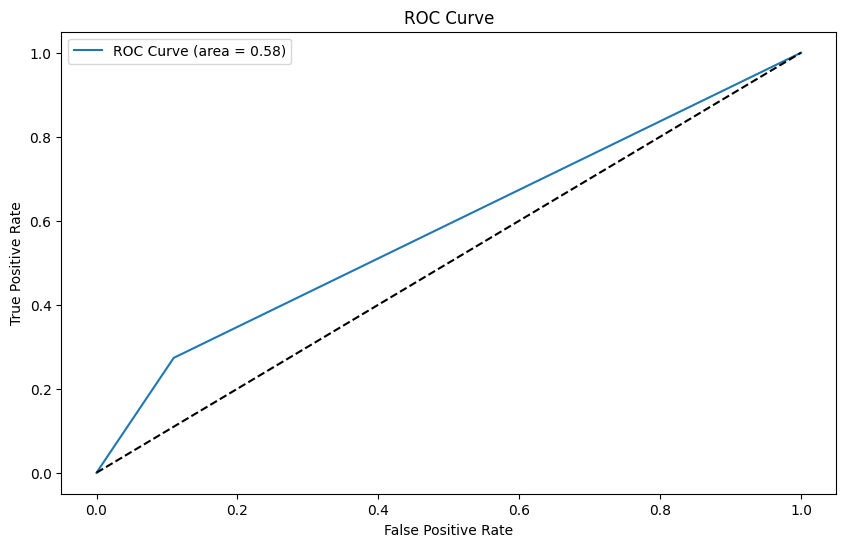

In [72]:
#Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, svm_test_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

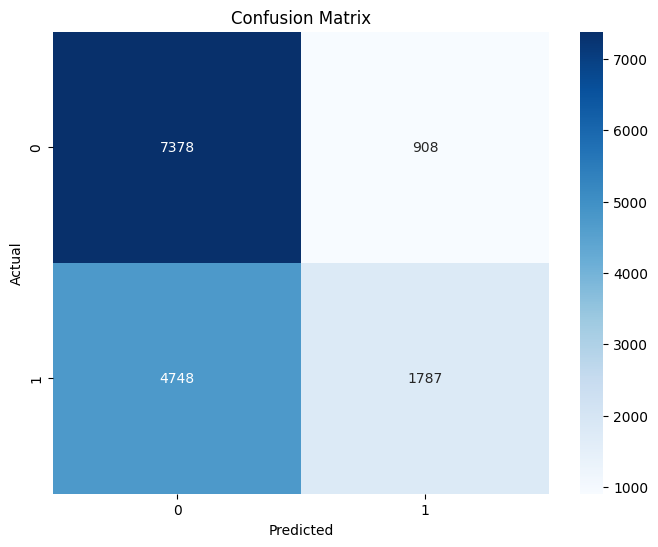

In [74]:

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [64]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

# Initialize the GridSearchCV object
grid_search = GridSearchCV(svm_model, param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)

# Fit the grid search to the data
# COMMENTED OUT - grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
grid_search_results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Update the svm_model with the best parameters
best_svm_model = grid_search.best_estimator_

In [91]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=2312, n_estimators=200)

In [92]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=2312)

In [93]:
val_rf_pred = random_forest_model.predict(X_val)

In [94]:
accuracy = accuracy_score(y_val, val_rf_pred)
precision = precision_score(y_val, val_rf_pred)
recall = recall_score(y_val, val_rf_pred)
f1 = f1_score(y_val, val_rf_pred)
roc_auc = roc_auc_score(y_val, val_rf_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.7175
Precision: 0.7452
Recall: 0.5442
F1 Score: 0.6290
ROC AUC: 0.6990


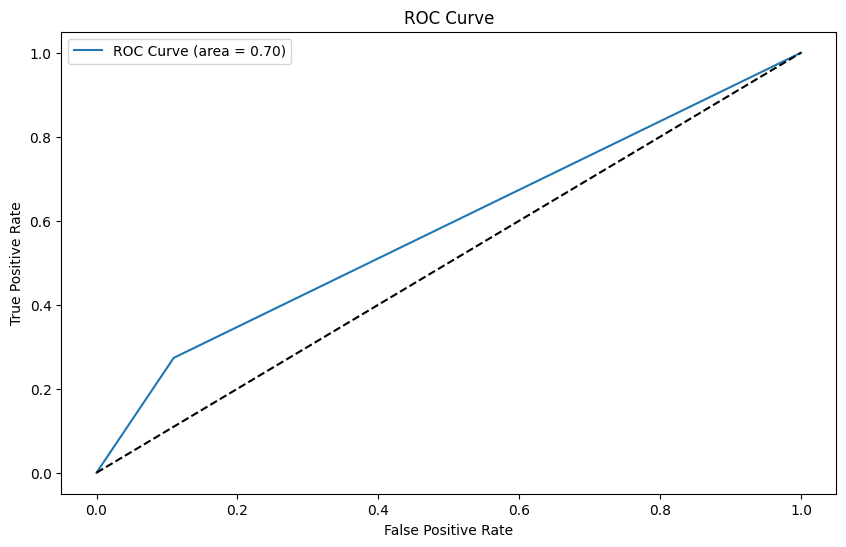

In [95]:
#Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, svm_test_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

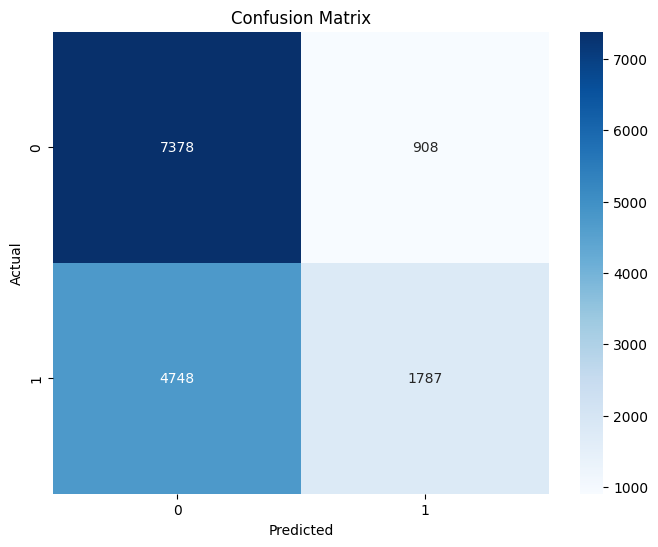

In [97]:

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/var/folders/3t/k_24wn2n031c8mww549l6s7h0000gn/T/ipykernel_41231/785036201.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


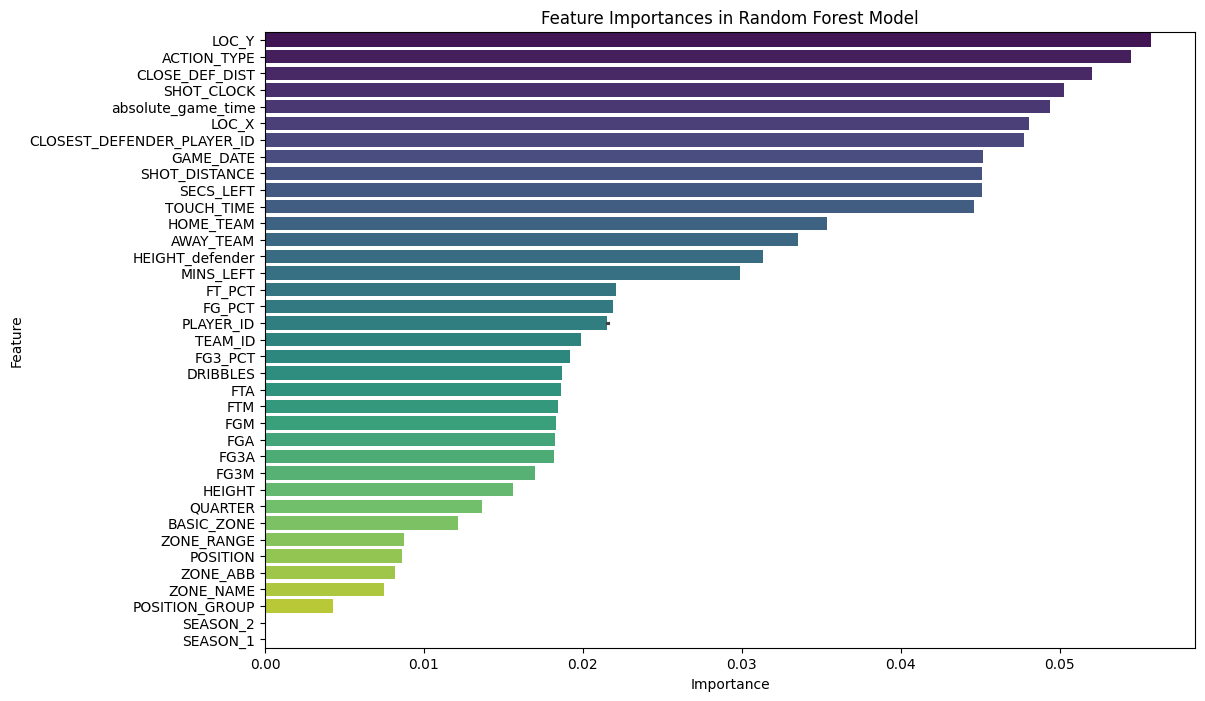

In [102]:
# Get feature importances from the random forest model
importances = random_forest_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances in Random Forest Model')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB


In [ ]:
#Naive bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

In [ ]:
y_pred_nb = nb_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_nb)
report = classification_report(y_test, y_pred_nb)

In [ ]:
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# יצירת מודל XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,  # מספר עצים
    learning_rate=0.1,  # קצב הלמידה
    max_depth=6,  # עומק העצים
    subsample=0.8,  # שימוש ב-80% מהדאטה בכל עץ
    colsample_bytree=0.8,  # שימוש ב-80% מהמשתנים בכל עץ
    random_state=42
)

In [ ]:
# המרת DataFrame לפורמט מתאים
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
# אימון המודל עם XGBoost
xgb_model.fit(X_train, y_train)

In [ ]:
# חיזוי על סט הבדיקה
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
# הצגת ביצועים
accuracy = accuracy_score(y_test, y_pred_xgb)
report = classification_report(y_test, y_pred_xgb)

In [ ]:
print(f'XGBoost Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)